-------------------------------------
Author: Shakir Ahmed

Topic: Credit card fraud detection using regression techniques and Neural networks

Data source: https://www.kaggle.com/mlg-ulb/creditcardfraud

-------------------------------------

**Context:**

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

\


**Content:**

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

## Importing packages

In [7]:
#importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

#importing packages for modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

In [3]:
#importing data from kaggle
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data processing and undersampling

We need to standardize the 'Amount' feature before modelling. For that, we use the StandardScaler function from sklearn. Then, we just have to drop the old feature :

<Axes: xlabel='Class', ylabel='count'>

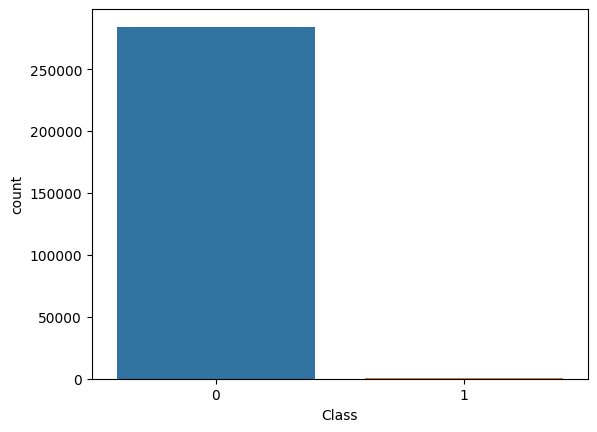

In [4]:
df = df.drop("Time", axis=1)
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

#standard scaling
df['std_Amount'] = scaler.fit_transform(df['Amount'].values.reshape (-1,1))

#removing Amount
df = df.drop("Amount", axis=1)

sns.countplot(x="Class", data=df)


The dataset exhibits a significant imbalance, posing a notable challenge as classifiers tend to predict the most prevalent class without thoroughly analyzing the features. This often results in a seemingly high accuracy rate, which, unfortunately, does not reflect the true predictive performance. To address this issue, I will employ random undersampling.

The basic approach to random undersampling involves the random selection of instances from the majority class, subsequently removing them from the training dataset. This method is commonly known as random undersampling. While it is straightforward and demonstrates effectiveness, it comes with a limitation. The technique removes examples without considering their potential utility or significance in determining the decision boundary between the classes. Consequently, there is a risk that valuable information may be inadvertently discarded.

To undersample, we can use the package imblearn with RandomUnderSampler function.



Text(0.5, 1.0, 'After')

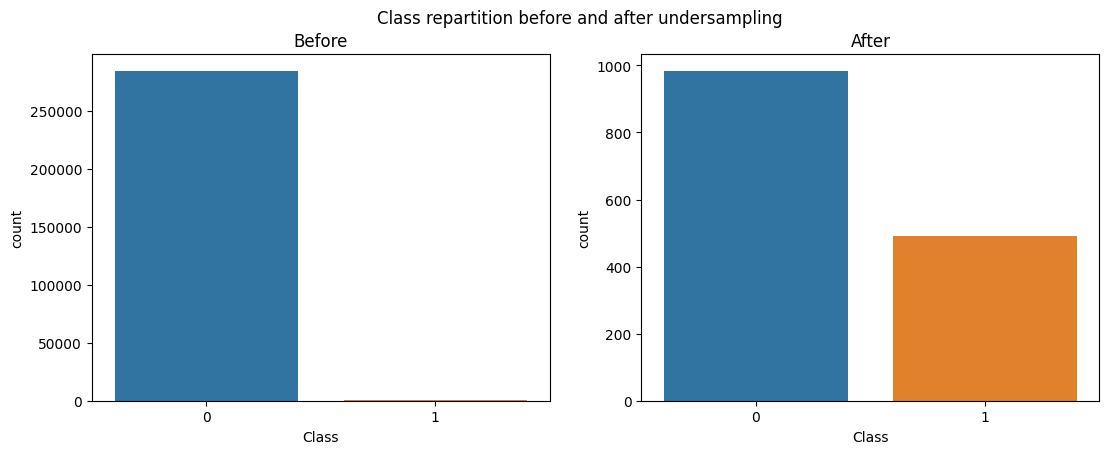

In [5]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy=0.5)

cols = df.columns.tolist()
cols = [c for c in cols if c not in ["Class"]]
target = "Class"

#define X and Y
X = df[cols]
Y = df[target]

#undersample
X_under, Y_under = undersample.fit_resample(X, Y)

from pandas import DataFrame
test = pd.DataFrame(Y_under, columns = ['Class'])

#visualizing undersampling results
fig, axs = plt.subplots(ncols=2, figsize=(13,4.5))
sns.countplot(x="Class", data=df, ax=axs[0])
sns.countplot(x="Class", data=test, ax=axs[1])

fig.suptitle("Class repartition before and after undersampling")
a1=fig.axes[0]
a1.set_title("Before")
a2=fig.axes[1]
a2.set_title("After")

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_under, Y_under, test_size=0.2, random_state=1)

## 1. Logistic regression

In [8]:
#train the model
model1 = LogisticRegression(random_state=2)
logit = model1.fit(X_train, y_train)

In [9]:
#predictions
y_pred_logit = model1.predict(X_test)

In [10]:
#scores
print("Accuracy Logit:",metrics.accuracy_score(y_test, y_pred_logit))
print("Precision Logit:",metrics.precision_score(y_test, y_pred_logit))
print("Recall Logit:",metrics.recall_score(y_test, y_pred_logit))
print("F1 Score Logit:",metrics.f1_score(y_test, y_pred_logit))

Accuracy Logit: 0.9594594594594594
Precision Logit: 0.9705882352941176
Recall Logit: 0.9166666666666666
F1 Score Logit: 0.9428571428571428


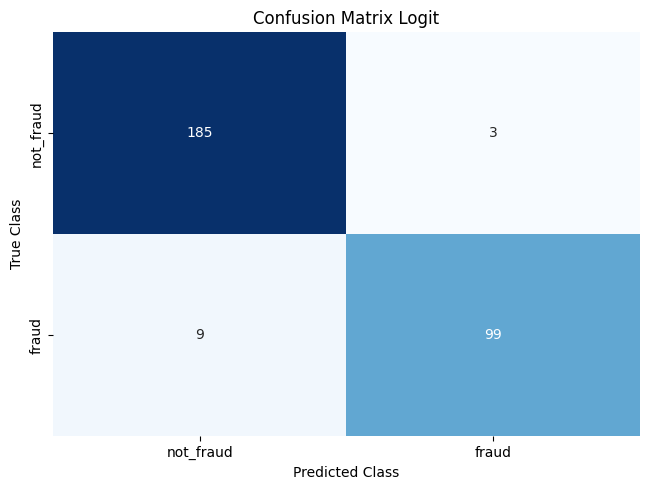

In [11]:
#print CM
matrix_logit = confusion_matrix(y_test, y_pred_logit)
cm_logit = pd.DataFrame(matrix_logit, index=['not_fraud', 'fraud'], columns=['not_fraud', 'fraud'])

sns.heatmap(cm_logit, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix Logit"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [12]:
#AUC
y_pred_logit_proba = model1.predict_proba(X_test)[::,1]
fpr_logit, tpr_logit, _ = metrics.roc_curve(y_test,  y_pred_logit_proba)
auc_logit = metrics.roc_auc_score(y_test, y_pred_logit_proba)
print("AUC Logistic Regression :", auc_logit)

AUC Logistic Regression : 0.9739952718676123


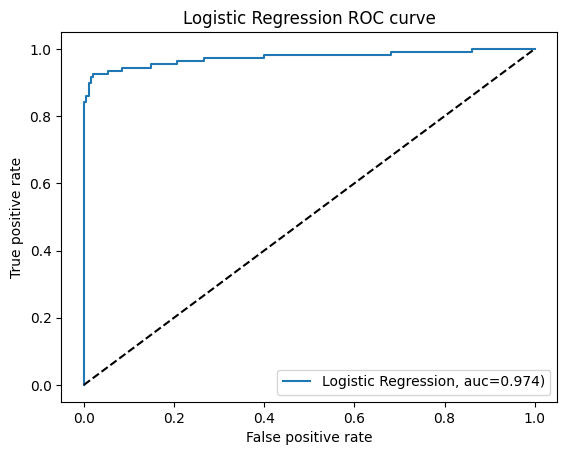

In [13]:
#ROC
plt.plot(fpr_logit,tpr_logit,label="Logistic Regression, auc={:.3f})".format(auc_logit))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression ROC curve')
plt.legend(loc=4)
plt.show()

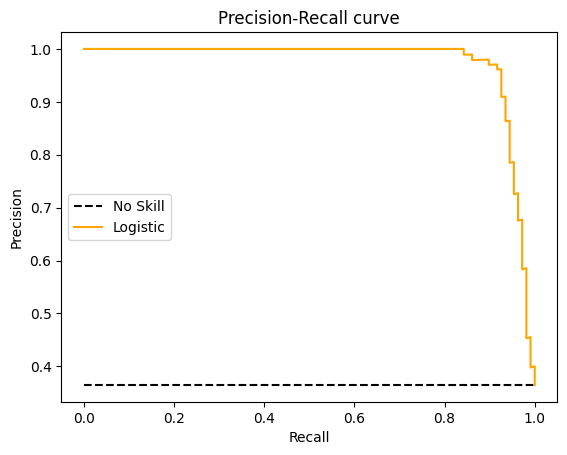

In [14]:
logit_precision, logit_recall, _ = precision_recall_curve(y_test, y_pred_logit_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(logit_recall, logit_precision, color='orange', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

Classification metrics for logistic regression:

1. Accuracy: 0.95
2. Precision: 0.97
3. Recall: 0.91
4. F1 Score: 0.94
5. AUC Logistic Regression : 0.97

## 2. Support Vector Machine

In [15]:
#train the model
model2 = SVC(probability=True, random_state=2)
svm = model2.fit(X_train, y_train)

#predictions
y_pred_svm = model2.predict(X_test)

In [16]:
#scores
print("Accuracy SVM:",metrics.accuracy_score(y_test, y_pred_svm))
print("Precision SVM:",metrics.precision_score(y_test, y_pred_svm))
print("Recall SVM:",metrics.recall_score(y_test, y_pred_svm))
print("F1 Score SVM:",metrics.f1_score(y_test, y_pred_svm))

Accuracy SVM: 0.9459459459459459
Precision SVM: 0.9893617021276596
Recall SVM: 0.8611111111111112
F1 Score SVM: 0.9207920792079208


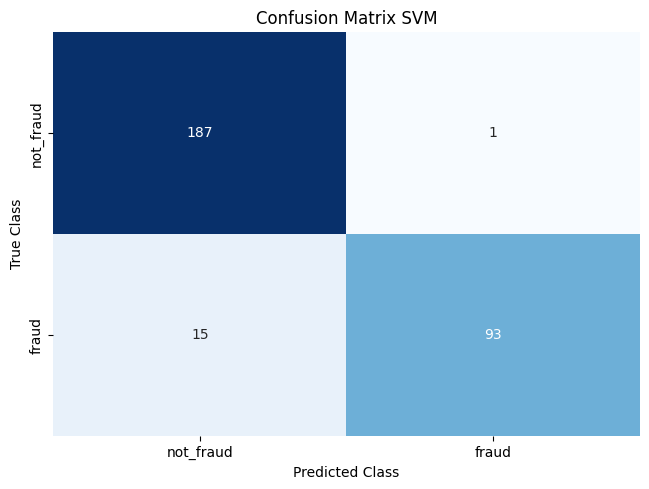

In [17]:
#CM matrix
matrix_svm = confusion_matrix(y_test, y_pred_svm)
cm_svm = pd.DataFrame(matrix_svm, index=['not_fraud', 'fraud'], columns=['not_fraud', 'fraud'])

sns.heatmap(cm_svm, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix SVM"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [18]:
#AUC
y_pred_svm_proba = model2.predict_proba(X_test)[::,1]
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_test,  y_pred_svm_proba)
auc_svm = metrics.roc_auc_score(y_test, y_pred_svm_proba)
print("AUC SVM :", auc_svm)

AUC SVM : 0.9730594956658787


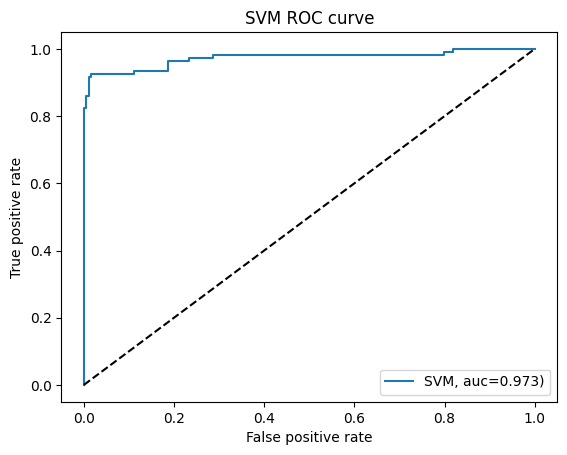

In [19]:
#ROC
plt.plot(fpr_svm,tpr_svm,label="SVM, auc={:.3f})".format(auc_svm))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('SVM ROC curve')
plt.legend(loc=4)
plt.show()

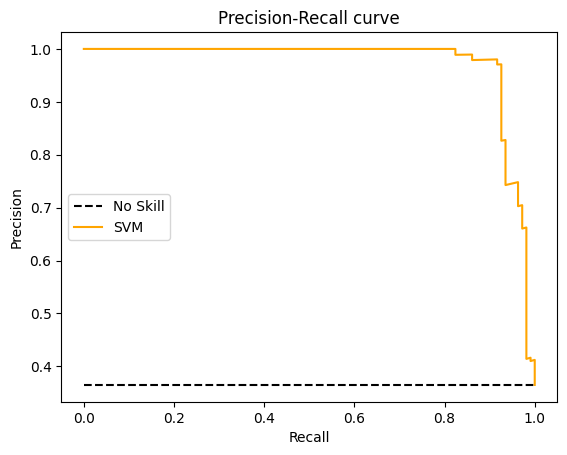

In [20]:
svm_precision, svm_recall, _ = precision_recall_curve(y_test, y_pred_svm_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(svm_recall, svm_precision, color='orange', label='SVM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

Classification metrics for SVM:
1. Accuracy SVM: 0.94
2. Precision SVM: 0.98
3. Recall SVM: 0.86
4. F1 Score SVM: 0.92
5. AUC SVM : 0.97

## 3. Ensemble learning : Bagging (Random Forest)

In [21]:
#train the model
model3 = RandomForestClassifier(random_state=2)
rf = model3.fit(X_train, y_train)

#predictions
y_pred_rf = model3.predict(X_test)

In [22]:
#scores
print("Accuracy RF:",metrics.accuracy_score(y_test, y_pred_rf))
print("Precision RF:",metrics.precision_score(y_test, y_pred_rf))
print("Recall RF:",metrics.recall_score(y_test, y_pred_rf))
print("F1 Score RF:",metrics.f1_score(y_test, y_pred_rf))

Accuracy RF: 0.9527027027027027
Precision RF: 0.9795918367346939
Recall RF: 0.8888888888888888
F1 Score RF: 0.9320388349514563


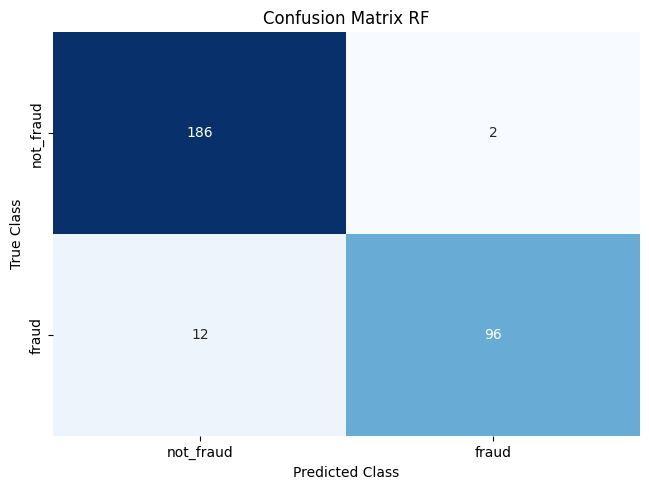

In [23]:
#CM matrix
matrix_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf = pd.DataFrame(matrix_rf, index=['not_fraud', 'fraud'], columns=['not_fraud', 'fraud'])

sns.heatmap(cm_rf, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix RF"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [24]:
#AUC
y_pred_rf_proba = model3.predict_proba(X_test)[::,1]
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test,  y_pred_rf_proba)
auc_rf = metrics.roc_auc_score(y_test, y_pred_rf_proba)
print("AUC Random Forest :", auc_rf)

AUC Random Forest : 0.9712618203309693


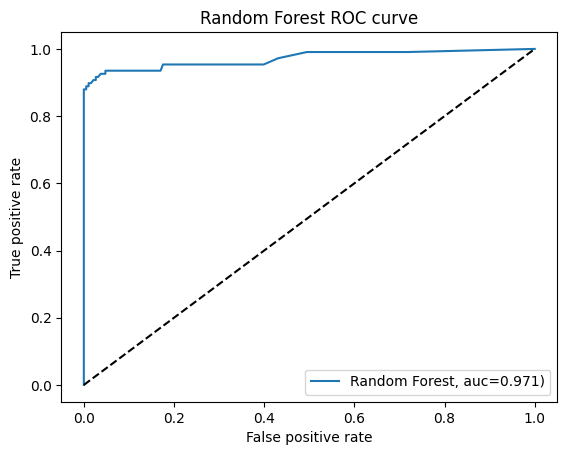

In [25]:
#ROC
plt.plot(fpr_rf,tpr_rf,label="Random Forest, auc={:.3f})".format(auc_rf))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Random Forest ROC curve')
plt.legend(loc=4)
plt.show()

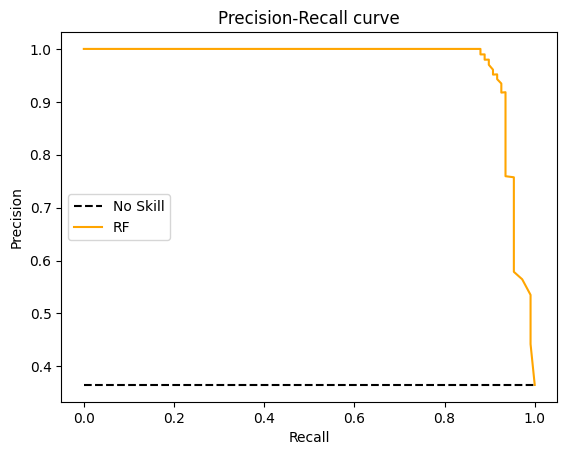

In [26]:
rf_precision, rf_recall, _ = precision_recall_curve(y_test, y_pred_rf_proba)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(rf_recall, rf_precision, color='orange', label='RF')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

Classfication metrics for random forest:
1. Accuracy RF: 0.95
2. Precision RF: 0.97
3. Recall RF: 0.88
4. F1 Score RF: 0.93
5. AUC Random Forest : 0.97

## 4. Ensemble learning : Boosting (XGBoost)

In [ ]:
#train the model
model4 = XGBClassifier(random_state=2)
xgb = model4.fit(X_train, y_train)

